## Stroke Prediction Dataset

Kaggle: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

### Leitura dos Dados

In [126]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')


# Modelos Base
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Modelos Baseados em Árvores
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Gradiente Boosting Moderno
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Métricas
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

In [127]:
df = pd.read_csv('../data/exports/treated_stroke_data.csv')
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,1,Self-employed,0,202.21,28.1,never smoked,1
2,Male,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1
3,Female,49.0,0,0,1,Private,1,171.23,34.4,smokes,1
4,Female,79.0,1,0,1,Self-employed,0,174.12,24.0,never smoked,1


---

## Modelo

#### Split Train/Test

In [128]:
X = df.drop("stroke", axis=1)
y = df["stroke"]                # Não vai ser preciso tratar a coluna-alvo, pois já está com valores binários

In [129]:
# separando features e target
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y,         # mantém proporção de classes
                                                    test_size=0.2, 
                                                    random_state=42)

In [130]:
print(f"\nDistribuição do target:")
print(y.value_counts(normalize=True))


Distribuição do target:
stroke
0    0.951262
1    0.048738
Name: proportion, dtype: float64


------------------------------------------------------------------------------------------------------------------------------------------------

#### Tratamento do smoking_status = Unknown

Como 30% dos dados para a coluna smoking_status é "Unknown", não dá para simplesmente excluir as colunas, é necessário tratá-la para imputar um valor que não prejudique a performance do dataset. Sendo assim, será utilizado o KNN como forma de preencher os valores faltantes por situações semelhantes para cada registro

In [131]:
X_train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
845,Female,48.0,0,0,1,Private,1,69.21,33.1,never smoked
3744,Female,29.0,0,0,0,Private,1,84.19,21.2,never smoked
4183,Female,35.0,0,0,1,Private,0,119.40,22.9,never smoked
3409,Male,38.0,0,0,1,Private,0,108.68,32.7,never smoked
284,Male,14.0,0,0,0,Govt_job,1,82.34,31.6,Unknown


In [132]:
print(f"\nTrain set: {X_train.shape[0]} registros ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:  {X_test.shape[0]} registros ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nUnknown no train: {(X_train['smoking_status'] == 'Unknown').sum()} ({(X_train['smoking_status'] == 'Unknown').sum() / len(X_train) * 100:.1f}%)")
print(f"Unknown no test:  {(X_test['smoking_status'] == 'Unknown').sum()} ({(X_test['smoking_status'] == 'Unknown').sum() / len(X_test) * 100:.1f}%)")


Train set: 4087 registros (80.0%)
Test set:  1022 registros (20.0%)

Unknown no train: 1236 (30.2%)
Unknown no test:  308 (30.1%)


### FASE 2: Pré-Processamento (Separado para Train e Test)

FASE 2.1: Codificação de Variáveis Categóricas

In [133]:
# Criar cópias para processamento
X_train_processed = X_train.copy()
X_test_processed = X_test.copy()

In [134]:
encoders = {}
categorical_cols = ['gender', 'work_type', 'Residence_type', 'smoking_status', 'ever_married']

for col in categorical_cols:
    le = LabelEncoder()
    X_train_processed[col] = le.fit_transform(X_train_processed[col].astype(str))
    X_test_processed[col] = le.transform(X_test_processed[col].astype(str))
    encoders[col] = le
    print(f"  {col}: {len(le.classes_)} classes → {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Verifica os tipos
print("\nTipos após encoding:")
print(X_train_processed.dtypes)

# Convertendo todos os dados para int
X_train_processed = X_train_processed.astype(int)
X_test_processed = X_test_processed.astype(int)

print("Tipos finais:")
print(X_train_processed.dtypes)

  gender: 2 classes → {'Female': np.int64(0), 'Male': np.int64(1)}
  work_type: 5 classes → {'Govt_job': np.int64(0), 'Never_worked': np.int64(1), 'Private': np.int64(2), 'Self-employed': np.int64(3), 'children': np.int64(4)}
  Residence_type: 2 classes → {'0': np.int64(0), '1': np.int64(1)}
  smoking_status: 4 classes → {'Unknown': np.int64(0), 'formerly smoked': np.int64(1), 'never smoked': np.int64(2), 'smokes': np.int64(3)}
  ever_married: 2 classes → {'0': np.int64(0), '1': np.int64(1)}

Tipos após encoding:
gender                 int64
age                  float64
hypertension           int64
heart_disease          int64
ever_married           int64
work_type              int64
Residence_type         int64
avg_glucose_level    float64
bmi                  float64
smoking_status         int64
dtype: object
Tipos finais:
gender               int64
age                  int64
hypertension         int64
heart_disease        int64
ever_married         int64
work_type            int64
R

In [135]:
print(X_train_processed.dtypes)
print(X_train_processed.isnull().sum())
print(X_train_processed.head())

gender               int64
age                  int64
hypertension         int64
heart_disease        int64
ever_married         int64
work_type            int64
Residence_type       int64
avg_glucose_level    int64
bmi                  int64
smoking_status       int64
dtype: object
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
dtype: int64
      gender  age  hypertension  heart_disease  ever_married  work_type  \
845        0   48             0              0             1          2   
3744       0   29             0              0             0          2   
4183       0   35             0              0             1          2   
3409       1   38             0              0             1          2   
284        1   14             0              0             0          0   

      Residence_type  

Fase 2.2: Imputação KNN

In [136]:
# Criar imputer KNN
knn_imputer = KNNImputer(n_neighbors=5)

In [137]:
# AJUSTAR com dados de TREINO
# Isto "aprende" o padrão dos dados conhecidos
print(f"\n  1. Ajustando KNN com {X_train_processed.shape[0]} registros de treino...")
X_train_imputed = knn_imputer.fit_transform(X_train_processed)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train_processed.columns)


  1. Ajustando KNN com 4087 registros de treino...


In [138]:
# Converter colunas categóricas de volta para inteiro
for col in categorical_cols:
    X_train_imputed[col] = X_train_imputed[col].round().astype(int)

print(f"  ✓ Train imputado")

  ✓ Train imputado


In [139]:
# APLICAR o mesmo imputer nos dados de TESTE
# Nota: Não reajusta, apenas usa o padrão aprendido do treino
print(f"  2. Aplicando KNN no test set (usando padrão do treino)...")
X_test_imputed = knn_imputer.transform(X_test_processed)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test_processed.columns)

  2. Aplicando KNN no test set (usando padrão do treino)...


In [140]:
# Converter colunas categóricas
for col in categorical_cols:
    X_test_imputed[col] = X_test_imputed[col].round().astype(int)

print(f"  ✓ Test imputado")

  ✓ Test imputado


In [141]:
# Converter smoking_status de volta para nomes legíveis (apenas para visualização)
le_smoking = encoders['smoking_status']  # Use o encoder específico
X_train_smoking_original = le_smoking.inverse_transform(X_train_imputed['smoking_status'].astype(int))
X_test_smoking_original = le_smoking.inverse_transform(X_test_imputed['smoking_status'].astype(int))

In [142]:
print(f"\n  Distribuição após imputação (Train):")
print(pd.Series(X_train_smoking_original).value_counts())


  Distribuição após imputação (Train):
never smoked       1520
Unknown            1236
formerly smoked     715
smokes              616
Name: count, dtype: int64


Fase 2.3: Normalização (Scaling)

In [143]:
# Criar StandardScaler
scaler = StandardScaler()

In [144]:
# Ajustar com treino
X_train_scaled = scaler.fit_transform(X_train_imputed)
print(f"  ✓ Scaler ajustado com treino")

  ✓ Scaler ajustado com treino


In [145]:
# Aplicar ao teste
X_test_scaled = scaler.transform(X_test_imputed)
print(f"  ✓ Scaler aplicado ao teste")

  ✓ Scaler aplicado ao teste


In [146]:
# Converter para DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_imputed.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_imputed.columns)

### Fase 3: Balanceamento (apenas no treino)

In [147]:
print(f"\nAntes do SMOTE:")
print(f"  Classe 0: {(y_train == 0).sum()} ({(y_train == 0).sum() / len(y_train) * 100:.1f}%)")
print(f"  Classe 1: {(y_train == 1).sum()} ({(y_train == 1).sum() / len(y_train) * 100:.1f}%)")


Antes do SMOTE:
  Classe 0: 3888 (95.1%)
  Classe 1: 199 (4.9%)


In [148]:
# Aplicar SMOTE apenas no treino
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

In [149]:
print(f"\nDepois do SMOTE:")
print(f"  Classe 0: {(y_train_balanced == 0).sum()} ({(y_train_balanced == 0).sum() / len(y_train_balanced) * 100:.1f}%)")
print(f"  Classe 1: {(y_train_balanced == 1).sum()} ({(y_train_balanced == 1).sum() / len(y_train_balanced) * 100:.1f}%)")


Depois do SMOTE:
  Classe 0: 3888 (50.0%)
  Classe 1: 3888 (50.0%)


### Fase 4: Treinamento dos Modelos

In [150]:
# 4. Instanciar modelos com parâmetros relevantes
arvore = DecisionTreeClassifier(
    random_state=42, 
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2
)

log_reg = LogisticRegression(
    max_iter=200,
    random_state=42,
    class_weight='balanced'
)

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

xgb = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=3,     # ajuda em classes minoritárias
    n_jobs=-1
)

catboost = CatBoostClassifier(
    iterations=100,
    depth=10,
    learning_rate=0.1,
    verbose=0,
    random_state=42,
    auto_class_weights='Balanced'
)

mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    max_iter=500,
    learning_rate_init=0.01,    # controla velocidade de aprendizado
    random_state=42
)

gaus = GaussianNB()

In [151]:
models = {
    'Decision Tree': arvore,
    'Logistic Regression': log_reg,
    'Random Forest': rf,
    'XGBoost': xgb,
    'CatBoost': catboost,
    'MLP': mlp,
    'Gaussian NB': gaus
}

In [152]:
# 5. Treinar modelos
arvore.fit(X_train_balanced, y_train_balanced) 
log_reg.fit(X_train_balanced, y_train_balanced) 
rf.fit(X_train_balanced, y_train_balanced) 
xgb.fit(X_train_balanced, y_train_balanced) 
catboost.fit(X_train_balanced, y_train_balanced)
mlp.fit(X_train_balanced, y_train_balanced) 
gaus.fit(X_train_balanced, y_train_balanced) 

,priors,None
,var_smoothing,1e-09


### Fase 5: Avaliação no Test set

In [153]:
# arvore
y_pred_arvore = arvore.predict(X_test_scaled)
y_pred_arvore_proba = arvore.predict_proba(X_test_scaled)[:, 1]

# log_reg
y_pred_log_reg = log_reg.predict(X_test_scaled)
y_pred_log_reg_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

# rf
y_pred_rf = rf.predict(X_test_scaled)
y_pred_rf_proba = rf.predict_proba(X_test_scaled)[:, 1]

# xgb
y_pred_xgb = xgb.predict(X_test_scaled)
y_pred_xgb_proba = xgb.predict_proba(X_test_scaled)[:, 1]

# catboost
y_pred_catboost = catboost.predict(X_test_scaled)
y_pred_catboost_proba = catboost.predict_proba(X_test_scaled)[:, 1]

# mlp
y_pred_mlp = mlp.predict(X_test_scaled)
y_pred_mlp_proba = mlp.predict_proba(X_test_scaled)[:, 1]

# gaus
y_pred_gaus = gaus.predict(X_test_scaled)
y_pred_gaus_proba = gaus.predict_proba(X_test_scaled)[:, 1]

In [154]:
print("=" * 80)
print("COMPARAÇÃO DE TODOS OS MODELS")
print("=" * 80)
print(f"{'model':<20} {'Accuracy':>10} {'Precision':>10} {'F1-Score':>10} {'AUC-ROC':>10}")
print("=" * 80)

for name, model in models.items():
    y_pred_model = model.predict(X_test_scaled)
    y_pred_model_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    acc = accuracy_score(y_test, y_pred_model)
    prec = precision_score(y_test, y_pred_model, zero_division=0)
    f1 = f1_score(y_test, y_pred_model, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_model_proba)
    
    print(f"{name:<20} {acc:>10.3f} {prec:>10.3f} {f1:>10.3f} {auc:>10.3f}")

print("=" * 80)

COMPARAÇÃO DE TODOS OS MODELS
model                  Accuracy  Precision   F1-Score    AUC-ROC
Decision Tree             0.833      0.115      0.174      0.668
Logistic Regression       0.746      0.138      0.235      0.837
Random Forest             0.865      0.172      0.250      0.791
XGBoost                   0.917      0.170      0.175      0.782
CatBoost                  0.902      0.179      0.219      0.795
MLP                       0.908      0.145      0.161      0.735
Gaussian NB               0.728      0.120      0.206      0.799


---

In [155]:
# ═════════════════════════════════════════════════════════════════════════════
# COMPARAÇÃO DE THRESHOLDS
# ═════════════════════════════════════════════════════════════════════════════

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

print("\n" + "="*80)
print("COMPARAÇÃO DE THRESHOLDS - Logistic Regression")
print("="*80)

thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]

for threshold in thresholds:
    y_pred_adj = (y_pred_log_reg_proba >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_adj)
    precision = precision_score(y_test, y_pred_adj)
    recall = recall_score(y_test, y_pred_adj)
    cm = confusion_matrix(y_test, y_pred_adj)
    
    print(f"\nThreshold {threshold}:")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  TP: {cm[0,0]}, FP: {cm[0,1]}, FN: {cm[1,0]}, TN: {cm[1,1]}")


COMPARAÇÃO DE THRESHOLDS - Logistic Regression

Threshold 0.2:
  F1-Score:  0.1533
  Precision: 0.0841
  Recall:    0.8600
  TP: 504, FP: 468, FN: 7, TN: 43

Threshold 0.3:
  F1-Score:  0.1746
  Precision: 0.0974
  Recall:    0.8400
  TP: 583, FP: 389, FN: 8, TN: 42

Threshold 0.4:
  F1-Score:  0.2064
  Precision: 0.1176
  Recall:    0.8400
  TP: 657, FP: 315, FN: 8, TN: 42

Threshold 0.5:
  F1-Score:  0.2353
  Precision: 0.1379
  Recall:    0.8000
  TP: 722, FP: 250, FN: 10, TN: 40

Threshold 0.6:
  F1-Score:  0.2879
  Precision: 0.1776
  Recall:    0.7600
  TP: 796, FP: 176, FN: 12, TN: 38


In [156]:
y_pred_final = (y_pred_log_reg_proba >= 0.6).astype(int)

print(f"Modelo Final com Threshold 0.6:")
print(f"  F1-Score: {f1_score(y_test, y_pred_final):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_final):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_final):.4f}")
print(f"  Confusion Matrix:\n{confusion_matrix(y_test, y_pred_final)}")

Modelo Final com Threshold 0.6:
  F1-Score: 0.2879
  Recall: 0.7600
  Precision: 0.1776
  Confusion Matrix:
[[796 176]
 [ 12  38]]


In [157]:
print(type(log_reg))
print(hasattr(log_reg, 'coef_'))

<class 'sklearn.linear_model._logistic.LogisticRegression'>
True


Este threshold diz respeito apenas ao modelo Logistic Regression. Abaixo, a comparação do threshold para todos os modelo:

In [158]:
# from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

print("="*80)
print("OTIMIZAÇÃO DE THRESHOLD - TODOS OS MODELOS")
print("="*80)

resultados_otimizados = {}

for name, model in models.items():
    print(f"\n{name}:")
    print("-" * 60)
    
    # Pegar probabilidades
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    melhor_f1 = 0
    melhor_threshold = 0.5
    melhor_metricas = {}
    
    for threshold in thresholds:
        y_pred_adj = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_test, y_pred_adj)
        precision = precision_score(y_test, y_pred_adj)
        recall = recall_score(y_test, y_pred_adj)
        
        print(f"  Threshold {threshold}: F1={f1:.4f} | Precision={precision:.4f} | Recall={recall:.4f}")
        
        # Guardar melhor
        if f1 > melhor_f1:
            melhor_f1 = f1
            melhor_threshold = threshold
            melhor_metricas = {
                'f1': f1,
                'precision': precision,
                'recall': recall
            }
    
    resultados_otimizados[name] = {
        'threshold': melhor_threshold,
        'metricas': melhor_metricas
    }
    
    print(f"  ✅ MELHOR: Threshold {melhor_threshold} → F1={melhor_f1:.4f}")

# Resumo final
print("\n" + "="*80)
print("RESUMO - MELHORES CONFIGURAÇÕES POR MODELO")
print("="*80)

for modelo, dados in resultados_otimizados.items():
    print(f"\n{modelo}:")
    print(f"  Threshold: {dados['threshold']}")
    print(f"  F1-Score: {dados['metricas']['f1']:.4f}")
    print(f"  Precision: {dados['metricas']['precision']:.4f}")
    print(f"  Recall: {dados['metricas']['recall']:.4f}")

OTIMIZAÇÃO DE THRESHOLD - TODOS OS MODELOS

Decision Tree:
------------------------------------------------------------
  Threshold 0.2: F1=0.1673 | Precision=0.1033 | Recall=0.4400
  Threshold 0.3: F1=0.1619 | Precision=0.1015 | Recall=0.4000
  Threshold 0.4: F1=0.1603 | Precision=0.1016 | Recall=0.3800
  Threshold 0.5: F1=0.1629 | Precision=0.1053 | Recall=0.3600
  Threshold 0.6: F1=0.1687 | Precision=0.1207 | Recall=0.2800
  ✅ MELHOR: Threshold 0.6 → F1=0.1687

Logistic Regression:
------------------------------------------------------------
  Threshold 0.2: F1=0.1533 | Precision=0.0841 | Recall=0.8600
  Threshold 0.3: F1=0.1746 | Precision=0.0974 | Recall=0.8400
  Threshold 0.4: F1=0.2064 | Precision=0.1176 | Recall=0.8400
  Threshold 0.5: F1=0.2353 | Precision=0.1379 | Recall=0.8000
  Threshold 0.6: F1=0.2879 | Precision=0.1776 | Recall=0.7600
  ✅ MELHOR: Threshold 0.6 → F1=0.2879

Random Forest:
------------------------------------------------------------
  Threshold 0.2: F1=0.18

### Feature Importance para o Logistic Regression

Feature Importance - Logistic Regression:
             Feature  Importance
9     smoking_status    0.000968
8                bmi    0.002930
4       ever_married    0.027186
0             gender    0.029311
5          work_type    0.035043
3      heart_disease    0.052771
6     Residence_type    0.115247
2       hypertension    0.146791
7  avg_glucose_level    0.188404
1                age    2.032209


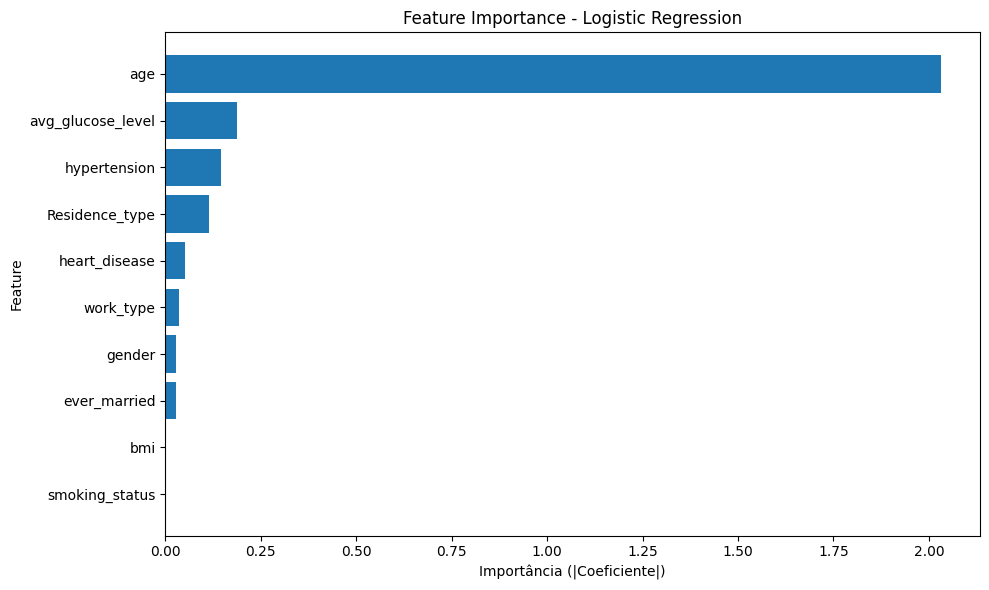

In [159]:
feature_importance_lr = pd.DataFrame({
    'Feature': X_test_scaled.columns,
    'Importance': np.abs(log_reg.coef_[0])  # Use [0] para pegar a primeira linha
}).sort_values('Importance', ascending=True)

print("Feature Importance - Logistic Regression:")
print(feature_importance_lr)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_lr['Feature'], feature_importance_lr['Importance'])
plt.xlabel('Importância (|Coeficiente|)')
plt.ylabel('Feature')
plt.title('Feature Importance - Logistic Regression')
plt.tight_layout()
plt.show()

### Matriz de Confusão

In [160]:
# log_reg = confusion_matrix(y_test, y_pred_final)
# sns.heatmap(log_reg, annot=True, fmt='d', cmap='Blues')
# plt.xlabel("Predicted")
# plt.ylabel("Real")
# plt.show()

### Fase 6: Exportando o modelo treinado

In [161]:
import pickle

In [162]:
# Salvar o modelo
model_path = '../data/processed/training_stroke_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(gaus, f)

print(f"✅ Modelo salvo em: {model_path}")

✅ Modelo salvo em: ../data/processed/training_stroke_model.pkl


In [163]:
# Também salvar o scaler
scaler_path = '../data/processed/scaler_stroke.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

print(f"✅ Scaler salvo em: {scaler_path}")

✅ Scaler salvo em: ../data/processed/scaler_stroke.pkl


In [164]:
# Salvar os encoders
encoders_path = '../data/processed/encoders_stroke.pkl'
with open(encoders_path, 'wb') as f:
    pickle.dump(encoders, f)

print(f"✅ Encoders salvos em: {encoders_path}")

✅ Encoders salvos em: ../data/processed/encoders_stroke.pkl
